In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Housing prices prediction in Iowa

The task: create a model that predicts the price of a house based on its characteristics.
Basis is a datase with 1460 houses and 79 describing features.  
Explanation of features can be found in the txt file data_description.
entered into Kaggle competition

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel
from sklearn import set_config
set_config(transform_output="pandas")

## Data Import

In [ ]:
houses_df = pd.read_csv('/data/train_regression.csv')

X = houses_df.copy().drop_duplicates()
X = X.drop(columns=["Id"])
y = X.pop("SalePrice")
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 12120)

In [4]:
X_train.shape

(1168, 79)

## Ordinal encoding

In [5]:
# define the order of the categories within each feature that will be encoded ordinal

ExterQual_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_ord = ["NA", "Po", "Mn", "Av", "Gd"]
BsmtFinType1_ord = ["NA", "unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
LotShape_ord = ["IR3","IR2", "IR1","Reg"]
Utilities_ord = ["ELO","NoSeWa","NoSewr","AllPub"]
HeatingQC_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_ord = ["NA","Unf", "RFn","Fin"]
GarageQual_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
PavedDrive_ord = ["N","P","Y"]
Fence_ord= ["NA", "MnWw","GdWo","MnPrv","GdPrv"]
BsmtFinType2_ord = ["NA", "unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"] 
CentralAir_ord  = ["N", "Y"]  
Functional_ord =   ["Sal", "Sev", "Maj2","Maj1", "Mod", "Min2", "Min1;Typ"]
GarageCond_ord =    ["NA","Po", "Fa", "TA", "Gd", "Ex"]
PoolQC_ord =       ["NA", "Fa", "TA", "Gd", "Ex"]
          

# dictionary with all features to pass into ordinal encoding
category_order= {"ExterQual": ExterQual_ord, 
            "ExterCond": ExterCond_ord,
            "BsmtQual": BsmtQual_ord,
            "BsmtCond": BsmtCond_ord,
            "BsmtExposure": BsmtExposure_ord,
            "BsmtFinType1": BsmtFinType1_ord, 
            "BsmtFinType2": BsmtFinType2_ord, #
            "KitchenQual": KitchenQual_ord,
            "FireplaceQu": FireplaceQu_ord,
            "LotShape" : LotShape_ord ,
            "Utilities" : Utilities_ord ,
            "HeatingQC" : HeatingQC_ord ,
            "GarageFinish" : GarageFinish_ord ,
            "GarageQual" : GarageQual_ord ,
            "PavedDrive" : PavedDrive_ord ,
            "Fence" : Fence_ord,
            "CentralAir" : CentralAir_ord,
            "Functional": Functional_ord,
            "GarageCond" : GarageCond_ord,
            "PoolQC" : PoolQC_ord    ,
               
               }



## Pipeline without scaler 
- Pipeline setup in a function
- Pipeline input

In [6]:
def no_scaling_pipe(model, X_cat, X_num, X_ord):
    """
    Creates the pipeline for preprocessing and modeling without scaling numerical features.

    Parameters:
    - model: The machine learning model to be used.
    - X_cat: The categorical features of the dataset.
    - X_num: The numerical features of the dataset.
    - X_ord: The ordinal features of the dataset.

    Returns:
    - no_scale_pipe: The machine learning pipeline without scaling numerical features.
    """

    # Create encoders for categorical and ordinal features
    hot = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
    ordinal = OrdinalEncoder(categories=[category_order[feature] for feature in category_order],
                             handle_unknown = "use_encoded_value",
                             unknown_value = -1)
    model_tree = SelectFromModel(DecisionTreeRegressor())
    
                                        
    # Create pipelines for numerical, categorical, and ordinal features
    num_pipe = make_pipeline(SimpleImputer())
    cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="unknown"), hot)
    ord_pipe = make_pipeline(SimpleImputer(strategy="constant",fill_value="unknown"), ordinal)

    # Create a column transformer to apply the pipelines to the respective features
    preprocessor = make_column_transformer(
        (num_pipe, X_num),
        (cat_pipe, X_cat),
        (ord_pipe, X_ord)
    )

    # Create the final pipeline by combining the preprocessor and the model
    no_scale_pipe = make_pipeline(preprocessor,model_tree,model)

    return no_scale_pipe

Division of the features into numerical, categorical and ordinal 

In [7]:
# select numerical features
X_num = X_train.select_dtypes(include="number").columns
#select non numerical featurs
no_nums = X_train.select_dtypes(exclude="number").columns.to_list()
# build a list with all columns that are keys in the dictionary category_order
X_ord = [ordinal for ordinal in no_nums if ordinal in category_order.keys()]
#build a list with the rest 
X_cat = [cat for cat in no_nums if not cat in category_order.keys()]


create the pipeline

In [8]:
model = GradientBoostingRegressor(random_state=12120)
full_pipe = no_scaling_pipe(model, X_cat,X_num,X_ord)

In [9]:
full_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'B...
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence'],
      dtype='object'))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=DecisionTreeRegressor())),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=12120))])

## Grid Search for best parameter set

In [10]:
parameter_forest = {"columntransformer__pipeline-1__simpleimputer__strategy":["median"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": [3],
                    "rfecv__estimator__max_depth":[10],
                    "rfecv__estimator__min_samples_split": [3],
                    "randomforestregressor__criterion":["squared_error"],
                    "randomforestregressor__max_depth": [11],
                    "randomforestregressor__min_samples_split": range(3,6),
                    "randomforestregressor__min_impurity_decrease": [0.005,]
                   }

parameter_gradient = {"columntransformer__pipeline-1__simpleimputer__strategy":["median"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": [3],
                    "selectfrommodel__threshold":["median","1.2*median", "mean"],
                    "selectfrommodel__estimator__max_depth":[10],
                    "selectfrommodel__estimator__min_samples_split": [3],
                    "gradientboostingregressor__loss":["absolute_error", "huber"],
                    "gradientboostingregressor__n_estimators": [100,120,150],
                    "gradientboostingregressor__criterion": ["friedman_mse"],
                    "gradientboostingregressor__max_depth": [10],
                    "gradientboostingregressor__min_samples_split": range(4,20,5),
                    "gradientboostingregressor__min_impurity_decrease": [0,0.005]
                   }

In [11]:
# setup of empty dictionaries for the training iterations to store results of variations
model_dict = {}
results_dict = {}
nr = 0

In [12]:
def grid_search(pipe, parameters, folds, X_train,y_train):

    grid_search = GridSearchCV( pipe,
                            parameters,
                            cv = 5,
                            scoring = "neg_mean_absolute_error",
                            verbose = 1
                          )
    return grid_search.fit(X_train,y_train)

applying the results and predict on X_test

In [13]:
#run the grid search function
grid_search = grid_search(full_pipe, parameter_gradient, 5, X_train,y_train)

# update the model dictionary with the best scores of the gridsearch
model_dict.update({f"Score_run_{nr}": grid_search.best_score_})
model_dict.update({f"param_run_{nr}": grid_search.best_params_})

#predict on test
y_pred = grid_search.best_estimator_.predict(X_test)

# update the results dictionary with the Scores on test set
results_dict.update({f"MAE_run_{nr}": mean_absolute_error(y_test, y_pred)})
results_dict.update({f"RMSE_run_{nr}":mean_squared_log_error(y_test, y_pred)})
results_dict.update({f"MAPE_run_{nr}": mean_absolute_percentage_error(y_test, y_pred)})
results_dict.update({f"R2_run_{nr}": r2_score(y_test, y_pred)})

nr = nr+1


In [14]:
results_dict

In [15]:
model_dict

## Submission

In [16]:
# define the parameters used for submission

parameter_final = {"columntransformer__pipeline-1__simpleimputer__strategy":["median"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": [3],
                    "selectfrommodel__threshold":["median"],
                    "selectfrommodel__estimator__max_depth":[10],
                    "selectfrommodel__estimator__min_samples_split": [3],
                    "gradientboostingregressor__loss":["absolute_error"],
                    "gradientboostingregressor__n_estimators": [150],
                    "gradientboostingregressor__criterion": ["friedman_mse"],
                    "gradientboostingregressor__max_depth": [10],
                    "gradientboostingregressor__min_samples_split": [14],
                    "gradientboostingregressor__min_impurity_decrease": [0]
                   }
# final GridSearch
search_final  = GridSearchCV( full_pipe,
                            parameter_final,
                            cv = 5,
                            scoring = "neg_mean_absolute_error",
                            verbose = 1
                          )


In [ ]:
# fit & predict
search_final.fit(X_train,y_train)
y_pred_fin= search_final.predict(X_test)

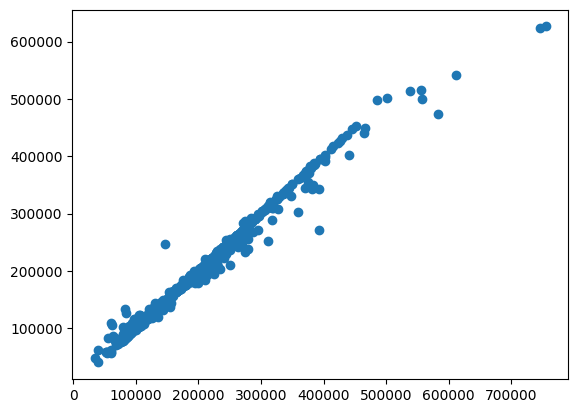

In [18]:
plt.scatter(y_train, search_final.predict(X_train))

In [19]:
#read the test csv
submission_df = pd.read_csv('/data/test_regression.csv')

In [20]:
# predict the submission model on test csv and keep only ID and SalePrice
my_submission = (
submission_df
    .assign(SalePrice = search_final.predict(submission_df))
    .filter(['Id','SalePrice'])
)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 13, 14, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
my_submission

,Id,SalePrice
0,1461,129250.265724
1,1462,160383.424899
2,1463,173108.469493
3,1464,185840.533465
4,1465,193036.876801
...,...,...
1454,2915,88009.911596
1455,2916,85856.092864
1456,2917,184147.238522
1457,2918,114973.472062


In [22]:
store submission
my_submission.to_csv("data/submission.csv", index=False)